In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '/home/tom/mpathic')


In [3]:
from mpathic import learn_model

First we import a test data set.

In [17]:
df = pd.read_csv("../../../data/processed_barcodes/20221114_barcode/LB_by_promoter/araCp_counts.csv")
df.head(5)

,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
0,228337,38677,GGCCATACTTTTTGAAGTAT,araCp,39,GTCATGTAGCATCCGCTAATCTTATGGATAAAAATACTATGGCTTA...
1,79171,2461,CATACCTCATGGTGTGCGTA,araCp,3,GTCAGGTAGGATGCGCTAATCTTATGGATAAAAATGCTATGGCATA...
2,62180,23612,GTATATGTACGTCCCTGCGA,araCp,178,GTCAGCTAGGATCCGGTAATCTTATGGATAAAACTGCTCTGGCATA...
3,56594,38141,TAATTCATACTTCGGCGCAG,araCp,56,GTCTGGTAGGATCCGCTAATCTTATGGATATAAATGCTAGGGCATG...
4,55044,36067,CTTGAAAGGCTCTGTGCGTA,araCp,62,GTCATGTAGGAGCCCCTAATCTTAGGGATAAAAATGCTATGGCATA...


Prep dataframe to work with mpathic, therefore renaming columns and sorting the dataframe.

In [18]:
df.rename(
    columns={
        "cDNA_count": "ct_1",
        "gDNA_count": "ct_0",
        "promoter": "seq"
    },
    inplace=True
)
df['ct'] = df['ct_0'] + df['ct_1']
df = df[['ct', 'ct_0', 'ct_1', 'seq']]
df.head(5)

,ct,ct_0,ct_1,seq
0,267014,38677,228337,GTCATGTAGCATCCGCTAATCTTATGGATAAAAATACTATGGCTTA...
1,81632,2461,79171,GTCAGGTAGGATGCGCTAATCTTATGGATAAAAATGCTATGGCATA...
2,85792,23612,62180,GTCAGCTAGGATCCGGTAATCTTATGGATAAAACTGCTCTGGCATA...
3,94735,38141,56594,GTCTGGTAGGATCCGCTAATCTTATGGATATAAATGCTAGGGCATG...
4,91111,36067,55044,GTCATGTAGGAGCCCCTAATCTTAGGGATAAAAATGCTATGGCATA...


Run mpathic on dataframe.

## Reg Seq data, re-processed

In [19]:
df_mcmc = pd.read_csv("araC_mcmc_mpathic_regseq_data.csv", index_col=0)
df_mcmc

,pos,val_A,val_C,val_G,val_T
0,0,0.038537,-0.001912,-0.074228,0.037604
1,1,-0.045047,0.007447,0.020856,0.016744
2,2,-0.052443,0.017856,-0.046508,0.081095
3,3,-0.030521,-0.014173,0.072689,-0.027995
4,4,-0.042022,-0.003341,0.013876,0.031487
...,...,...,...,...,...
155,155,0.027005,0.007337,0.000180,-0.034523
156,156,-0.036090,-0.025498,0.055264,0.006324
157,157,-0.036004,-0.004552,-0.033063,0.073619
158,158,0.027449,-0.001293,-0.014283,-0.011873


In [20]:
mcmc_arr = df_mcmc[['val_A', 'val_C', 'val_G', 'val_T']].to_numpy()

Transform phenotype output to probabilities using exponential distribution.

In [21]:
norm = np.sum(np.exp(mcmc_arr), axis=1)
exp_vec = [np.exp(mcmc_arr)[i, :] / norm[i] for i in range(160)] 
rel_entropy = [np.sum([x[i] * np.log2(x[i] / 0.25) for i in range(4)]) for x in exp_vec]

Text(0.5, 1.0, 'araC in LB')

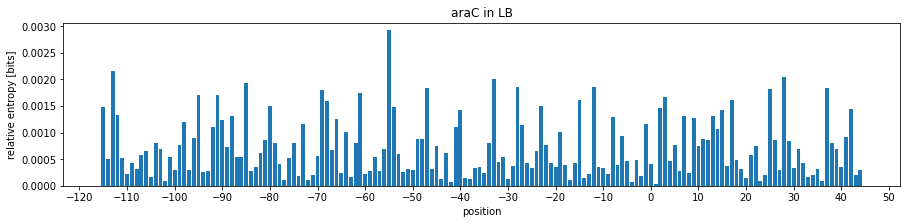

In [22]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(-115, 45), rel_entropy)
ax.set_xlabel('position')
ax.set_xticks(np.linspace(-120, 50, 18))
ax.set_ylabel('relative entropy [bits]')
ax.set_title('araC in LB')

Text(0.5, 1.0, 'araC in LB')

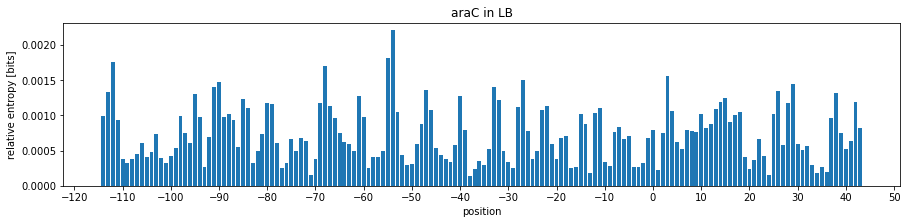

In [23]:
fig, ax = plt.subplots(figsize=(15, 3))

d = 1

ax.bar(np.arange(-115+d, 45-d), [np.mean(rel_entropy[i-d:i+d]) for i in range(d, 160-d)])
ax.set_xlabel('position')
ax.set_xticks(np.linspace(-120, 50, 18))
ax.set_ylabel('relative entropy [bits]')
ax.set_title('araC in LB')

In [24]:
df_mcmc = pd.read_csv("araC_mcmc_mpathic.csv", index_col=0)
df_mcmc

,val_A,val_C,val_G,val_T
pos,,,,
0,0.015578,-0.050710,0.037741,-0.002609
1,-0.053156,0.022418,-0.018185,0.048923
2,0.017396,-0.018946,-0.015235,0.016785
3,-0.039689,-0.001317,0.007370,0.033635
4,-0.006576,-0.006401,-0.008738,0.021715
...,...,...,...,...
155,-0.010166,0.039864,-0.032712,0.003014
156,0.009200,-0.012482,0.032375,-0.029093
157,0.009612,0.003716,-0.000593,-0.012736


In [25]:
mcmc_arr = df_mcmc[['val_A', 'val_C', 'val_G', 'val_T']].to_numpy()

Transform phenotype output to probabilities using exponential distribution.

In [26]:
norm = np.sum(np.exp(mcmc_arr), axis=1)
exp_vec = [np.exp(mcmc_arr)[i, :] / norm[i] for i in range(160)] 
rel_entropy = [np.sum([x[i] * np.log2(x[i] / 0.25) for i in range(4)]) for x in exp_vec]

Text(0.5, 1.0, 'araC in LB')

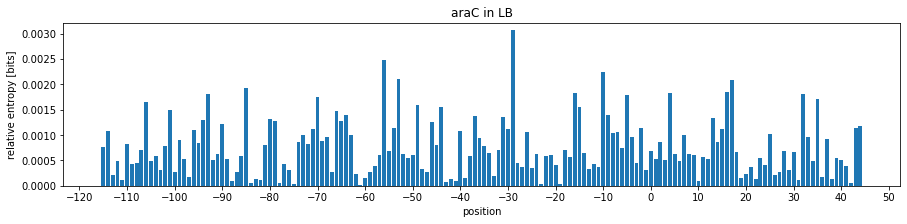

In [27]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(np.arange(-115, 45), rel_entropy)
ax.set_xlabel('position')
ax.set_xticks(np.linspace(-120, 50, 18))
ax.set_ylabel('relative entropy [bits]')
ax.set_title('araC in LB')

Text(0.5, 1.0, 'rspA in LB')

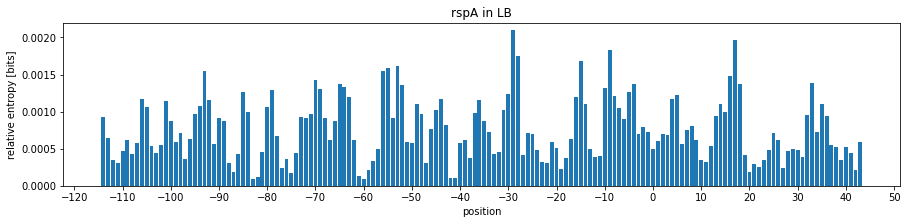

In [28]:
fig, ax = plt.subplots(figsize=(15, 3))

d = 1

ax.bar(np.arange(-115+d, 45-d), [np.mean(rel_entropy[i-d:i+d]) for i in range(d, 160-d)])
ax.set_xlabel('position')
ax.set_xticks(np.linspace(-120, 50, 18))
ax.set_ylabel('relative entropy [bits]')
ax.set_title('rspA in LB')